In [1]:
# Bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar Google Drive
from google.colab import drive
import os

# Montar o diretório do projeto
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/ML_Salvador')

Mounted at /content/drive


In [12]:
# Carregar dados meterológicos/pré-processamento
met = pd.read_csv('POA_Meteorologia.csv', sep=';', index_col=False)

met.dropna(inplace=True)

if pd.api.types.is_string_dtype(met['hora']):
  met['hora'] = met['hora'].str.strip()
else:
  met['hora'] = met['hora'].astype(str).str.zfill(4)  # Adicionar zeros à esquerda

met['data'] = pd.to_datetime(met['data'])

met['datetime'] = pd.to_datetime(met['data'].dt.strftime('%Y-%m-%d') + met['hora'], format='%Y-%m-%d%H%M')

met['rad_solar'] = met['rad_solar'].where(met['rad_solar'] >= 0, 0)

print(met.head())
print(met.shape)

        data  hora  prec_total  pressao_atm  rad_solar  temperatura  \
0 2017-01-01  0000         0.0       1000.7        0.0         26.0   
1 2017-01-01  0100         0.0       1001.4        0.0         25.5   
2 2017-01-01  0200         0.0       1002.1        0.0         25.1   
3 2017-01-01  0300         0.0       1002.6        0.0         23.7   
4 2017-01-01  0400         0.0       1002.4        0.0         23.0   

   temp_max_hr  temp_min_hr  umid_relativa  dir_vento  veloc_vento  \
0         26.5         25.9           78.0      341.0          2.1   
1         26.0         25.5           77.0      323.0          1.5   
2         25.5         25.0           79.0      323.0          0.7   
3         25.0         23.7           87.0      150.0          0.4   
4         23.7         23.0           90.0       74.0          0.2   

             datetime  
0 2017-01-01 00:00:00  
1 2017-01-01 01:00:00  
2 2017-01-01 02:00:00  
3 2017-01-01 03:00:00  
4 2017-01-01 04:00:00  
(34080, 

In [13]:
# Processamento dos dados meteorológicos, cálculo de médias e cumulativos diários
def deg_to_rad(degrees):
    return np.deg2rad(degrees)

def rad_to_deg(radians):
    return np.rad2deg(radians)

met_daily = met.resample('D', on='data').agg({
    'pressao_atm': 'mean',
    'temperatura': 'mean',
    'umid_relativa': 'mean',
    'dir_vento': lambda x: (rad_to_deg(np.arctan2(np.mean(np.sin(deg_to_rad(x)) * met.loc[x.index, 'veloc_vento']),
                                                    np.mean(np.cos(deg_to_rad(x)) * met.loc[x.index, 'veloc_vento']))) + 360) % 360,
    'veloc_vento': 'mean',
    'prec_total': 'sum',
    'rad_solar': lambda x: x.sum() / 1e3, # KJ to MJ
    'temp_max_hr': 'max',
    'temp_min_hr': 'min'
})


met_daily = met_daily.reset_index()

met_daily.rename(columns={'temperatura': 'temp_med_dia',
                        'rad_solar': 'dose',
                        'temp_max_hr': 'temp_max_dia',
                        'temp_min_hr': 'temp_min_dia'}, inplace=True)

met_daily['dia_juliano'] = met_daily['data'].dt.dayofyear
met_daily['dia_semana'] = met_daily['data'].dt.dayofweek
met_daily['data_unix'] = met_daily['data'].astype(int) // 10**9

print(met_daily.head())
print(met_daily.shape)

        data  pressao_atm  temp_med_dia  umid_relativa   dir_vento  \
0 2017-01-01  1002.537500     27.350000      75.916667  277.642821   
1 2017-01-02  1005.383333     27.241667      79.791667  132.099916   
2 2017-01-03  1004.400000     27.475000      75.791667   97.473276   
3 2017-01-04  1002.100000     25.208333      85.666667  223.497211   
4 2017-01-05  1003.875000     24.720833      86.500000  259.035638   

   veloc_vento  prec_total       dose  temp_max_dia  temp_min_dia  \
0     1.595833         0.0  27.588722          33.0          22.4   
1     1.312500         0.0  19.698622          31.6          24.3   
2     1.450000         0.0  25.897676          34.6          22.5   
3     1.829167        78.8  19.298059          33.3          20.9   
4     1.091667        10.8  19.248597          31.2          21.5   

   dia_juliano  dia_semana   data_unix  
0            1           6  1483228800  
1            2           0  1483315200  
2            3           1  1483401600  


In [14]:
# Variáveis categóricas

# Adicionar coluna com a estação do ano (one-hot)
def map_to_season(month):
    if month in [12, 1, 2]:    # Verão: Dez, Jan, Fev
        return 'verao'
    elif month in [3, 4, 5]:   # Outono: Mar, Abr, Maio
        return 'outono'
    elif month in [6, 7, 8]:   # Inverno: Jun, Jul, Ago
        return 'inverno'
    elif month in [9, 10, 11]: # Verão: Set, Out, Nov
        return 'primavera'

met_daily['est'] = met_daily['data'].dt.month.map(map_to_season)

met_daily = pd.get_dummies(met_daily, columns=['est'], drop_first=False, dtype=float)

# Direção do vento em setores (one-hot)
def map_to_wind_direction(degrees):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    boundaries = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    for i in range(len(boundaries) - 1):
        if boundaries[i] <= degrees < boundaries[i + 1]:
            return directions[i]

met_daily['dir_vento'] = met_daily['dir_vento'].apply(map_to_wind_direction)

met_daily = pd.get_dummies(met_daily, columns=['dir_vento'], drop_first=False, dtype=float)

print(met_daily.head())
print(met_daily.shape)

        data  pressao_atm  temp_med_dia  umid_relativa  veloc_vento  \
0 2017-01-01  1002.537500     27.350000      75.916667     1.595833   
1 2017-01-02  1005.383333     27.241667      79.791667     1.312500   
2 2017-01-03  1004.400000     27.475000      75.791667     1.450000   
3 2017-01-04  1002.100000     25.208333      85.666667     1.829167   
4 2017-01-05  1003.875000     24.720833      86.500000     1.091667   

   prec_total       dose  temp_max_dia  temp_min_dia  dia_juliano  ...  \
0         0.0  27.588722          33.0          22.4            1  ...   
1         0.0  19.698622          31.6          24.3            2  ...   
2         0.0  25.897676          34.6          22.5            3  ...   
3        78.8  19.298059          33.3          20.9            4  ...   
4        10.8  19.248597          31.2          21.5            5  ...   

   est_primavera  est_verao  dir_vento_E  dir_vento_N  dir_vento_NE  \
0            0.0        1.0          0.0          0.0    

In [15]:
# Carregar dados do DataSUS/pré-processamento
datasus = pd.read_csv('POA_DataSUS.csv', delimiter=',', index_col=False)

datasus['data'] = pd.to_datetime(datasus['DT_INTER'], format='%Y%m%d')

datasus.drop(columns=['UF_ZI', 'N_AIH', 'IDENT', 'CEP', 'MUNIC_RES',
                      'MUNIC_MOV', 'UTI_MES_TO', 'UTI_INT_TO', 'DIAR_ACOM',
                      'QT_DIARIAS', 'US_TOT', 'COD_IDADE', 'MORTE', 'IDADE'], inplace=True)

# datasus = datasus[datasus['IDADE_ANOS'] <= 5] # Filtrar para apenas crianças < 5 anos

datasus.rename(columns={'DT_INTER': 'data_intern',
                        'DT_SAIDA': 'data_saida',
                        'SEXO': 'sexo',
                        'DIAG_PRINC': 'diag_princ',
                        'DIAS_PERM': 'dias_intern',
                        'IDADE_ANOS': 'idade'}, inplace=True)

datasus['freq_intern'] = datasus.groupby('data')['diag_princ'].transform('count')
datasus['idade_med'] = datasus.groupby('data')['idade'].transform('median')
datasus['idade_mod'] = datasus.groupby('data')['idade'].transform(lambda x: x.mode()[0])
datasus['dias_intern_med'] = datasus.groupby('data')['dias_intern'].transform('median')
datasus['dias_intern_mod'] = datasus.groupby('data')['dias_intern'].transform(lambda x: x.mode()[0])
# datasus['sexo_mod'] = datasus.groupby('data')['sexo'].transform(lambda x: x.mode()[0])

datasus_daily = datasus[['data', 'freq_intern', 'idade_med', 'dias_intern_med', 'idade_mod', 'dias_intern_mod']].drop_duplicates('data')

print(datasus_daily.head())
print(datasus_daily.shape)

# Opcional - Salvar matriz como .csv
# datasus.to_csv("Matriz_DataSUS.csv", index=False)

          data  freq_intern  idade_med  dias_intern_med  idade_mod  \
0   2017-01-01           16       58.0              5.0       0.58   
16  2017-01-02           35       57.0              4.0       0.83   
51  2017-01-03           38       48.5              6.5      59.00   
89  2017-01-04           30       50.5              4.5       0.25   
119 2017-01-05           38       47.5              6.5      61.00   

     dias_intern_mod  
0                  1  
16                 1  
51                 7  
89                 1  
119                4  
(1461, 6)


In [16]:
# União das as duas matrizes
merged_data = pd.merge(met_daily, datasus_daily[['data', 'freq_intern', 'idade_med', 'dias_intern_med', 'idade_mod', 'dias_intern_mod']], on='data', how='inner')

merged_data.dropna(inplace=True)

print(merged_data.head())
print(merged_data.shape)

# Opcional - Salvar matriz como .csv
merged_data.to_csv("Matriz_Meteorologia_FreqCID-J.csv", index=False)

        data  pressao_atm  temp_med_dia  umid_relativa  veloc_vento  \
0 2017-01-01  1002.537500     27.350000      75.916667     1.595833   
1 2017-01-02  1005.383333     27.241667      79.791667     1.312500   
2 2017-01-03  1004.400000     27.475000      75.791667     1.450000   
3 2017-01-04  1002.100000     25.208333      85.666667     1.829167   
4 2017-01-05  1003.875000     24.720833      86.500000     1.091667   

   prec_total       dose  temp_max_dia  temp_min_dia  dia_juliano  ...  \
0         0.0  27.588722          33.0          22.4            1  ...   
1         0.0  19.698622          31.6          24.3            2  ...   
2         0.0  25.897676          34.6          22.5            3  ...   
3        78.8  19.298059          33.3          20.9            4  ...   
4        10.8  19.248597          31.2          21.5            5  ...   

   dir_vento_NW  dir_vento_S  dir_vento_SE  dir_vento_SW  dir_vento_W  \
0           0.0          0.0           0.0           0.

In [7]:
# Adicionando um atraso de k dias nas variáveis independentes
merged_data_lagged = merged_data.copy()

lagged_column = 'freq_intern'
merged_data_lagged['freq_intern_1d'] = merged_data_lagged[lagged_column].shift(-1)

lagged_column = 'freq_intern'
merged_data_lagged['freq_intern_2d'] = merged_data_lagged[lagged_column].shift(-2)

lagged_column = 'freq_intern'
merged_data_lagged['freq_intern_3d'] = merged_data_lagged[lagged_column].shift(-3)

lagged_column = 'freq_intern'
merged_data_lagged['freq_intern_4d'] = merged_data_lagged[lagged_column].shift(-4)

lagged_column = 'freq_intern'
merged_data_lagged['freq_intern_5d'] = merged_data_lagged[lagged_column].shift(-5)

merged_data_lagged.dropna(inplace=True)

print(merged_data_lagged.head())
print(merged_data_lagged.shape)

# Opcional - Salvar matriz como .csv
# merged_data_lagged.to_csv("Matriz_Meteorologia_FreqCID-J_lag.csv", index=False)

        data  pressao_atm  temp_med_dia  umid_relativa  veloc_vento  \
0 2017-01-01  1002.537500     27.350000      75.916667     1.595833   
1 2017-01-02  1005.383333     27.241667      79.791667     1.312500   
2 2017-01-03  1004.400000     27.475000      75.791667     1.450000   
3 2017-01-04  1002.100000     25.208333      85.666667     1.829167   
4 2017-01-05  1003.875000     24.720833      86.500000     1.091667   

   prec_total       dose  temp_max_dia  temp_min_dia  dia_juliano  ...  \
0         0.0  27.588722          33.0          22.4            1  ...   
1         0.0  19.698622          31.6          24.3            2  ...   
2         0.0  25.897676          34.6          22.5            3  ...   
3        78.8  19.298059          33.3          20.9            4  ...   
4        10.8  19.248597          31.2          21.5            5  ...   

   freq_intern  idade_med  dias_intern_med  idade_mod  dias_intern_mod  \
0           16       58.0              5.0       0.58 

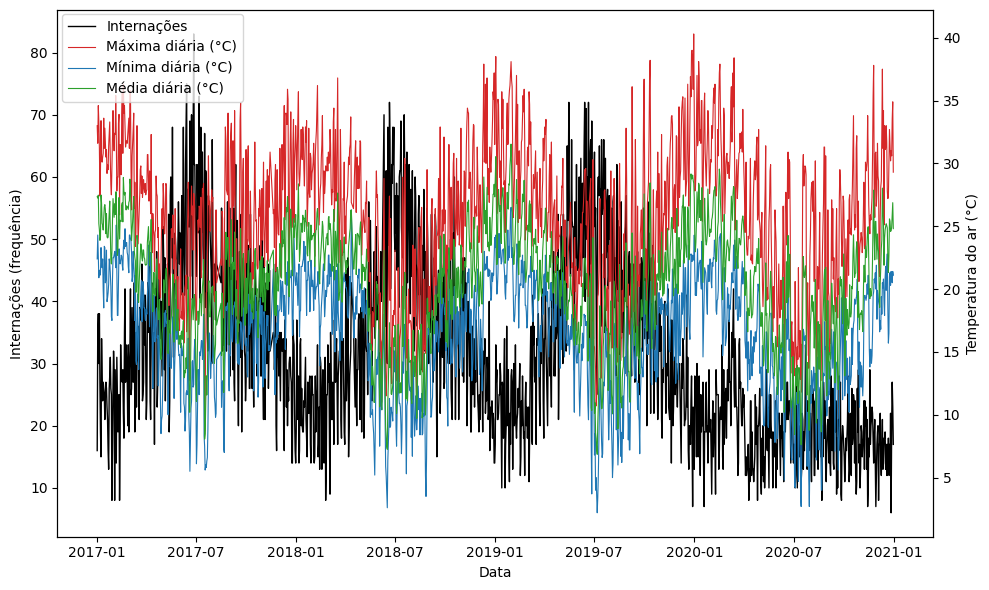

In [8]:
# Série temporal - temperaturas vs. frequência

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Data')
ax1.set_ylabel('Internações (frequência)', color='black')
ax1.plot(merged_data['data'], merged_data['freq_intern'], label='Internações', color='black', linewidth=1)
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperatura do ar (°C)', color='black')
ax2.plot(merged_data['data'], merged_data['temp_max_dia'], label='Máxima diária (°C)', color='tab:red', linewidth=.8)
ax2.plot(merged_data['data'], merged_data['temp_min_dia'], label='Mínima diária (°C)', color='tab:blue', linewidth=.8)
ax2.plot(merged_data['data'], merged_data['temp_med_dia'], label='Média diária (°C)', color='tab:green', linewidth=.8)
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.06, 0.98))

plt.show()

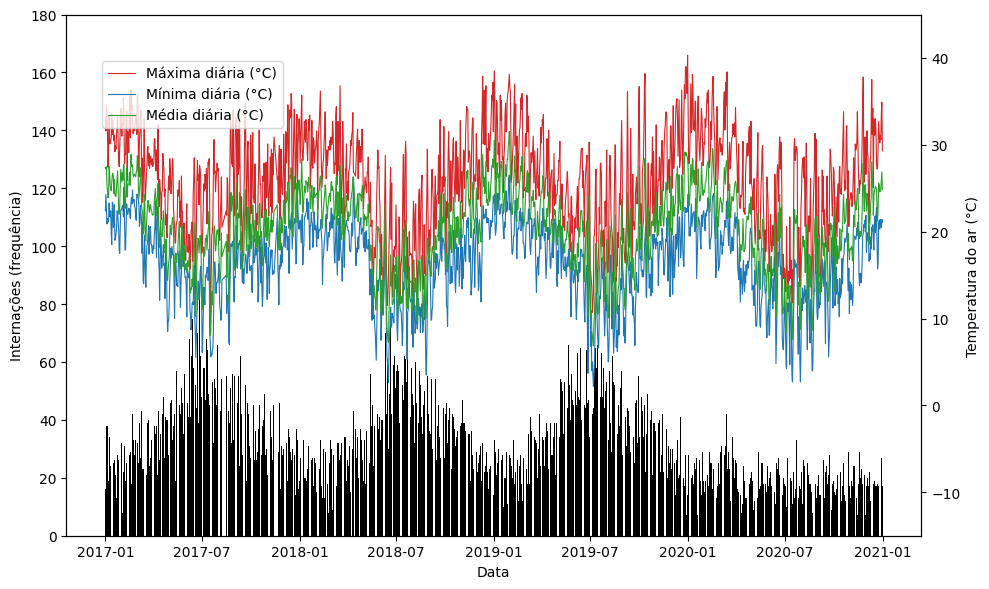

In [ ]:
# Série temporal - temperaturas vs. frequência (gráfico de barras)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'black'
ax1.set_xlabel('Data')
ax1.set_ylabel('Internações (frequência)', color=color)
ax1.bar(merged_data['data'], merged_data['freq_intern'], color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 180])

ax2 = ax1.twinx()

ax2.plot(merged_data['data'], merged_data['temp_max_dia'], label='Máxima diária (°C)', color='tab:red', linewidth=.8)
ax2.plot(merged_data['data'], merged_data['temp_min_dia'], label='Mínima diária (°C)', color='tab:blue', linewidth=.8)
ax2.plot(merged_data['data'], merged_data['temp_med_dia'], label='Média diária (°C)', color='tab:green', linewidth=.8)
ax2.set_ylabel('Temperatura do ar (°C)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([-15, 45])

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()

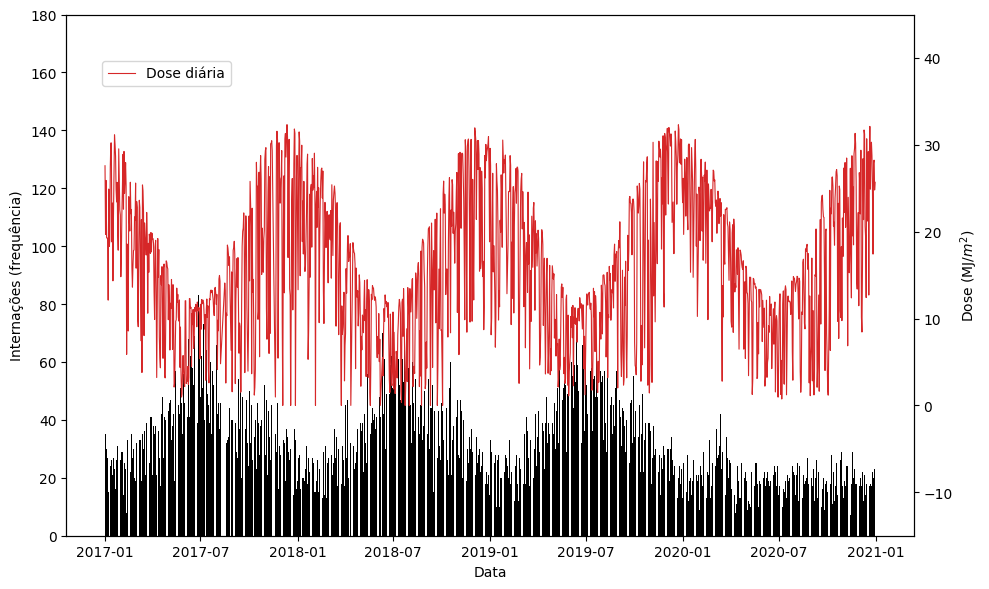

In [ ]:
# Série temporal - dose vs. frequência (gráfico de barras)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'black'
ax1.set_xlabel('Data')
ax1.set_ylabel('Internações (frequência)', color=color)
ax1.bar(merged_data['data'], merged_data['freq_intern'], color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 180])

ax2 = ax1.twinx()

ax2.plot(merged_data['data'], merged_data['dose'], label='Dose diária', color='tab:red', linewidth=.8)
ax2.set_ylabel('Dose (MJ/$m^2$)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([-15, 45])

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()

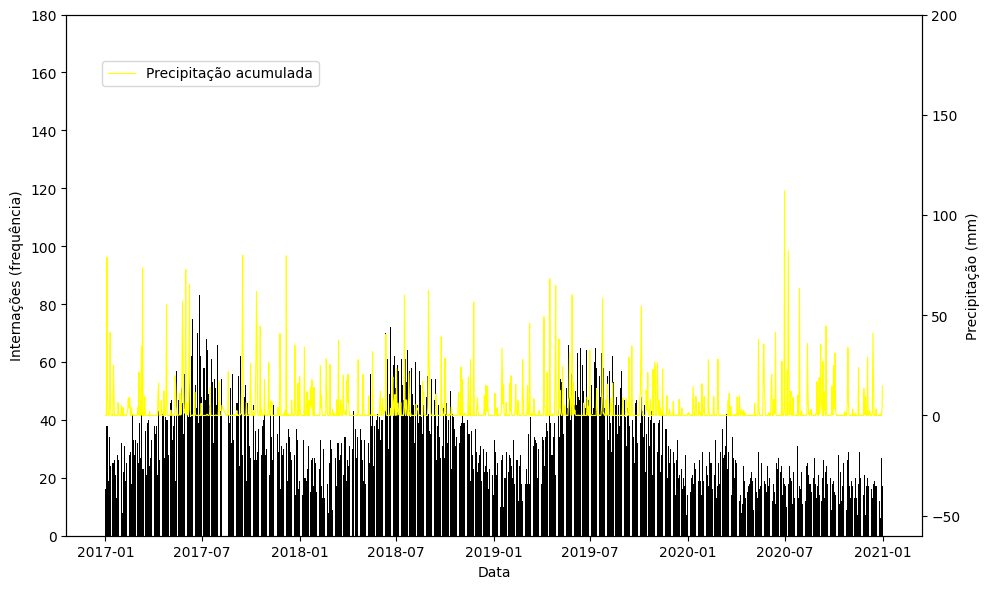

In [ ]:
# Série temporal - precipitação vs. frequência (gráfico de barras)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'black'
ax1.set_xlabel('Data')
ax1.set_ylabel('Internações (frequência)', color=color)
ax1.bar(merged_data['data'], merged_data['freq_intern'], color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 180])

ax2 = ax1.twinx()

ax2.plot(merged_data['data'], merged_data['prec_total'], label='Precipitação acumulada', color='yellow', linewidth=.8)
ax2.set_ylabel('Precipitação (mm)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([-60, 200])

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()

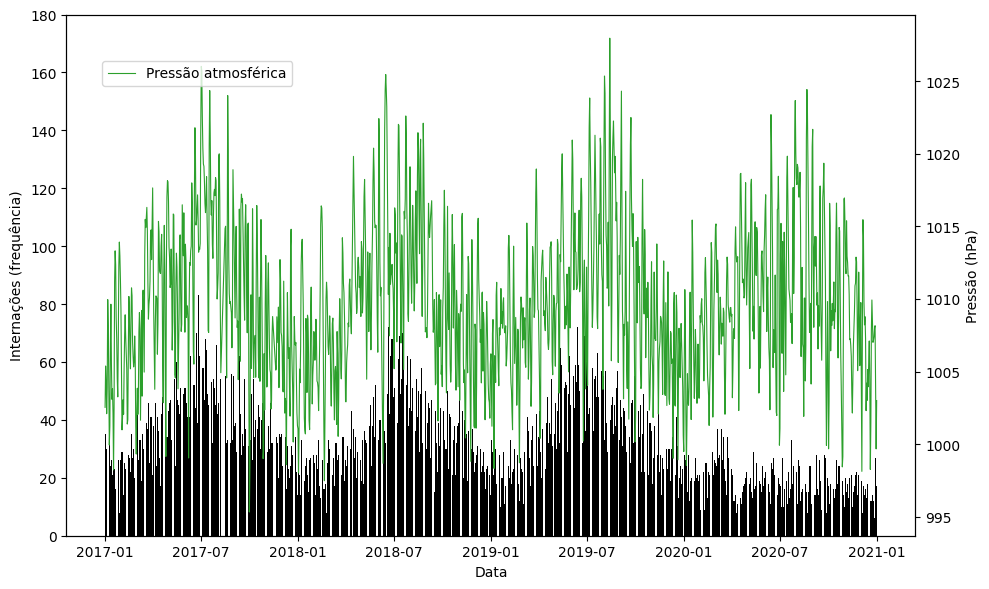

In [ ]:
# Série temporal - pressão vs. frequência (gráfico de barras)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'black'
ax1.set_xlabel('Data')
ax1.set_ylabel('Internações (frequência)', color=color)
ax1.bar(merged_data['data'], merged_data['freq_intern'], color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 180])

ax2 = ax1.twinx()

ax2.plot(merged_data['data'], merged_data['pressao_atm'], label='Pressão atmosférica', color='tab:green', linewidth=.8)
ax2.set_ylabel('Pressão (hPa)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()

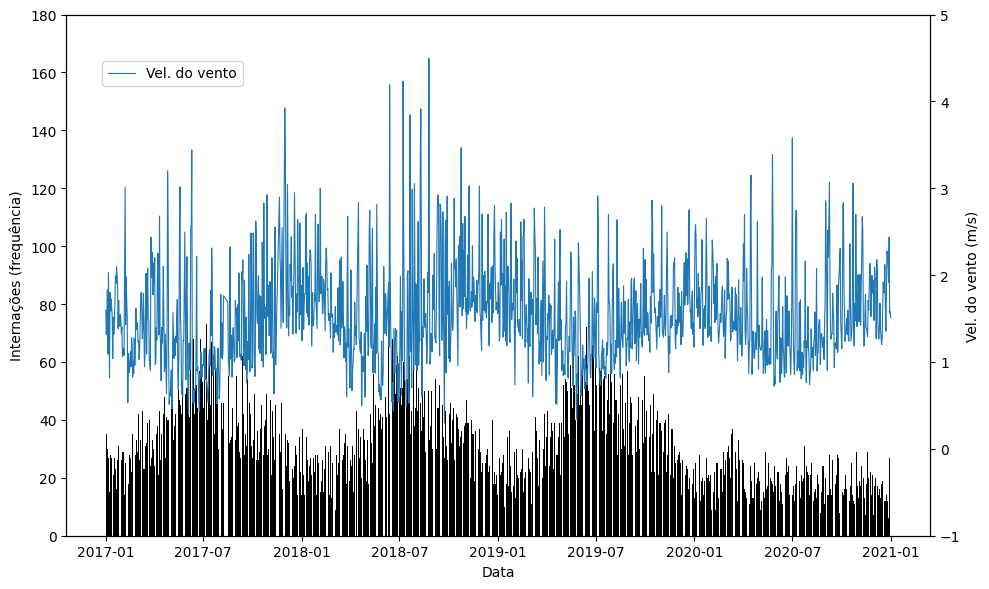

In [ ]:
# Série temporal - vento vs. frequência (gráfico de barras)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'black'
ax1.set_xlabel('Data')
ax1.set_ylabel('Internações (frequência)', color=color)
ax1.bar(merged_data['data'], merged_data['freq_intern'], color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 180])

ax2 = ax1.twinx()

ax2.plot(merged_data['data'], merged_data['veloc_vento'], label='Vel. do vento', color='tab:blue', linewidth=.8)
ax2.set_ylabel('Vel. do vento (m/s)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([-1, 5])

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()